In [10]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from utilities.data_manager import ExchangeDataManager

In [11]:
def simulate_close(period, sigma, mu, initial_price, time):
    mu = mu * period # drift
    sigma = sigma * np.sqrt(period) # volatitlity
    delta = 1 / period

    wiener_process = sigma * np.random.normal(loc=0, scale=np.sqrt(delta), size=time)
    gbm = np.exp(
        wiener_process + (mu - sigma**2 / 2) * delta
    )
    simul = initial_price * gbm.cumprod(axis=0)
    return simul

def simulate_ohlc(close, period, sigma, time):
    ds = pd.DataFrame()
    ds["close"] = close
    ds["open"] = ds["close"].shift(1)
    mu = 0 # drift
    sigma = sigma * np.sqrt(period) # volatitlity
    delta = 1 / period

    wiener_process_high = sigma * abs(np.random.normal(loc=0, scale=np.sqrt(delta), size=time))
    wiener_process_low = sigma * abs(np.random.normal(loc=0, scale=np.sqrt(delta), size=time))
    gbm_high = np.exp(
        wiener_process_high + (mu - sigma**2 / 2) * delta
    )
    gbm_low = np.exp(
        wiener_process_low + (mu - sigma**2 / 2) * delta
    )
    ds["high"] = gbm_high * ds[['open', 'close']].max(axis=1)
    ds["low"] = (1 - (gbm_low-1)) * ds[['open', 'close']].min(axis=1)
    ds = ds.fillna(method='bfill')
    return ds

def generate_fake_data(df, period):
    # setup params for brownian motion
    initial_price = df.iloc[0]["close"]
    sigma = df["close"].pct_change().std()
    mu = df["close"].pct_change().mean()
    time = len(df)

    fake_close = simulate_close(period, sigma, mu, initial_price, time)

    sigma_high_low = ((df["high"] - df[['open', 'close']].max(axis=1)) / df[['open', 'close']].max(axis=1)).std() * 1.5
    fake_ohlc = simulate_ohlc(fake_close, period, sigma_high_low, time)
    fake_ohlc.index = df.index
    return fake_ohlc

In [12]:
exchange_name = "binance"
pair = "BTC/USDT"
tf = "1h"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="../database/exchanges"
)

df = exchange.load_data(pair, tf)
df

,open,high,low,close,volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2023-01-23 09:00:00,22719.28,22788.00,22703.26,22784.18,6806.103800
2023-01-23 10:00:00,22784.85,22957.25,22764.91,22909.95,12356.087740
2023-01-23 11:00:00,22909.95,22930.00,22826.23,22904.58,10145.716830


In [13]:
ds = generate_fake_data(df, 365*24)
ds

,close,open,high,low
date,,,,
2017-08-17 04:00:00,4314.985758,4314.985758,4371.976802,4307.857218
2017-08-17 05:00:00,4252.265659,4314.985758,4324.384397,4237.725225
2017-08-17 06:00:00,4250.509221,4252.265659,4266.342347,4241.513260
2017-08-17 07:00:00,4258.057030,4250.509221,4296.652704,4224.514842
2017-08-17 08:00:00,4323.802907,4258.057030,4338.327580,4231.965821
...,...,...,...,...
2023-01-23 09:00:00,15281.979048,15318.204013,15373.203536,15195.824301
2023-01-23 10:00:00,15220.300966,15281.979048,15372.958102,15161.657275
2023-01-23 11:00:00,15215.886052,15220.300966,15256.631363,15107.748668


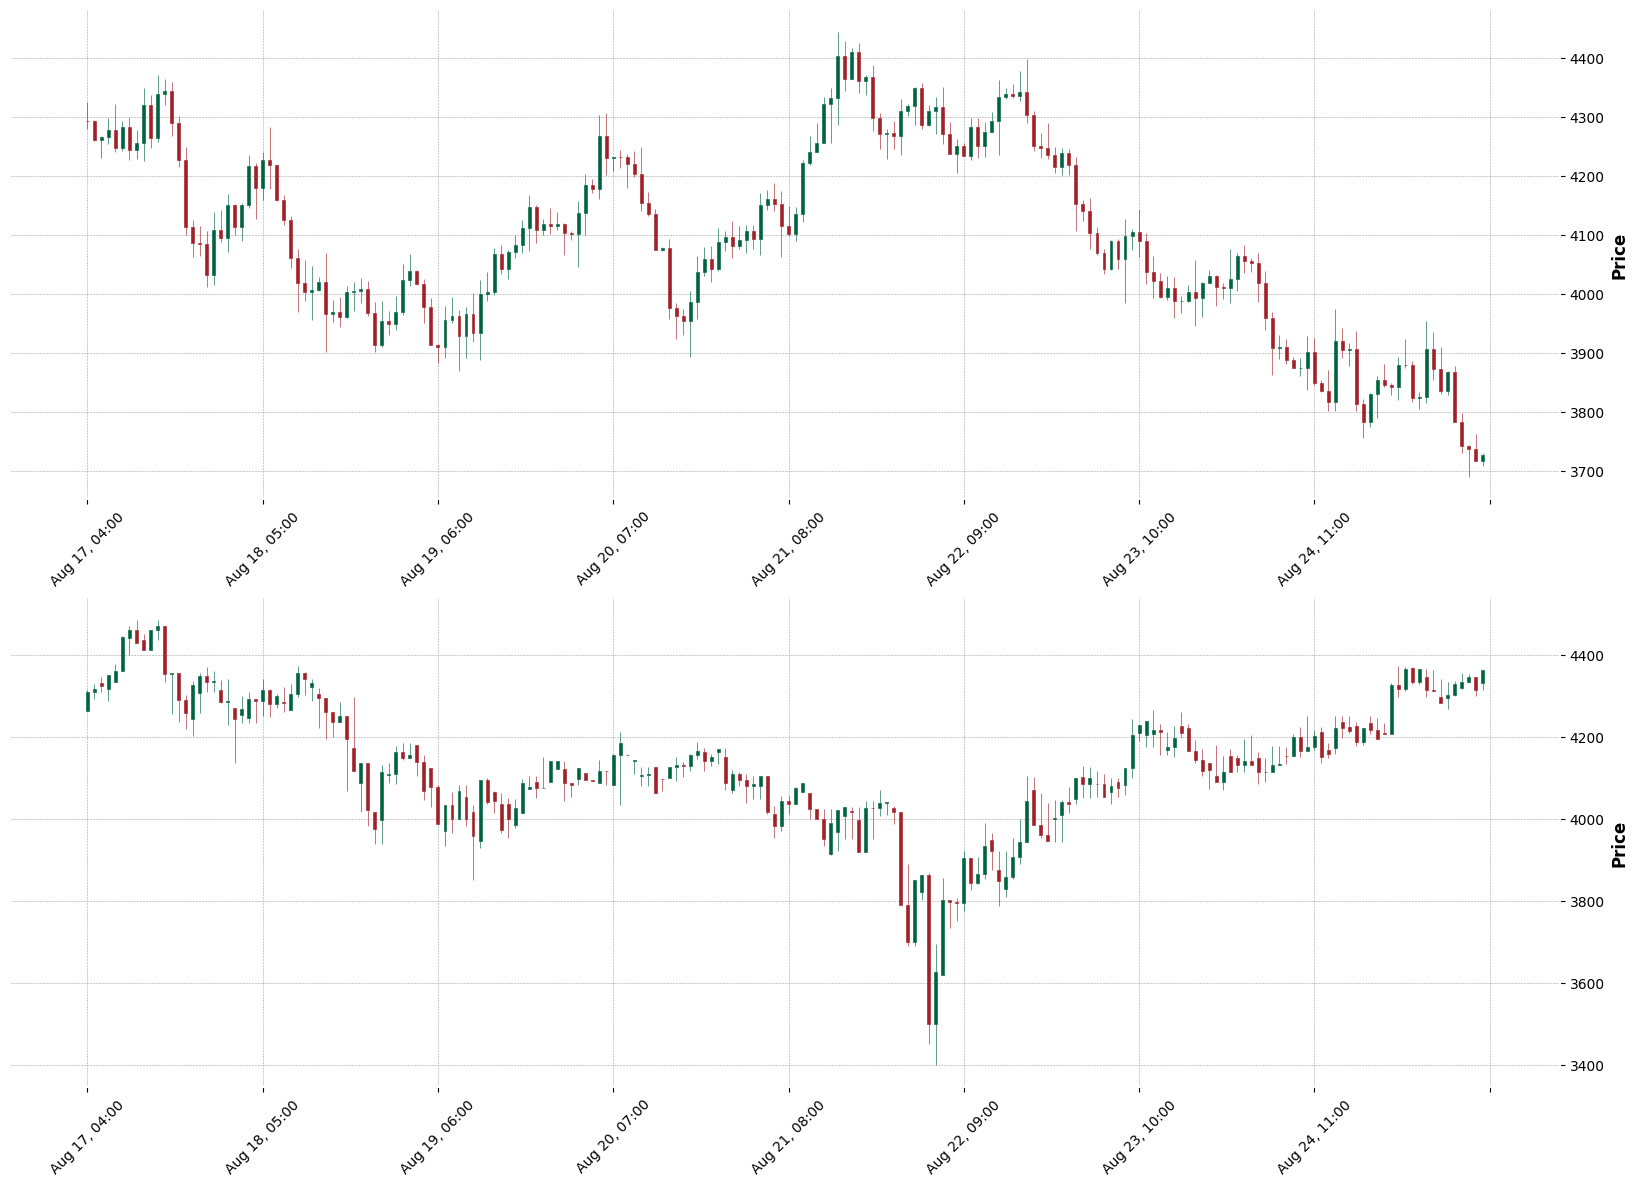

In [14]:
ds = generate_fake_data(df, 365)
fig = mpf.figure(1, figsize=(20, 14), style='charles')
axis = fig.subplots(2)
mpf.plot(ds.iloc[:200], type='candle', style='charles', ax=axis[0])
mpf.plot(df.iloc[:200], type='candle', style='charles', ax=axis[1])

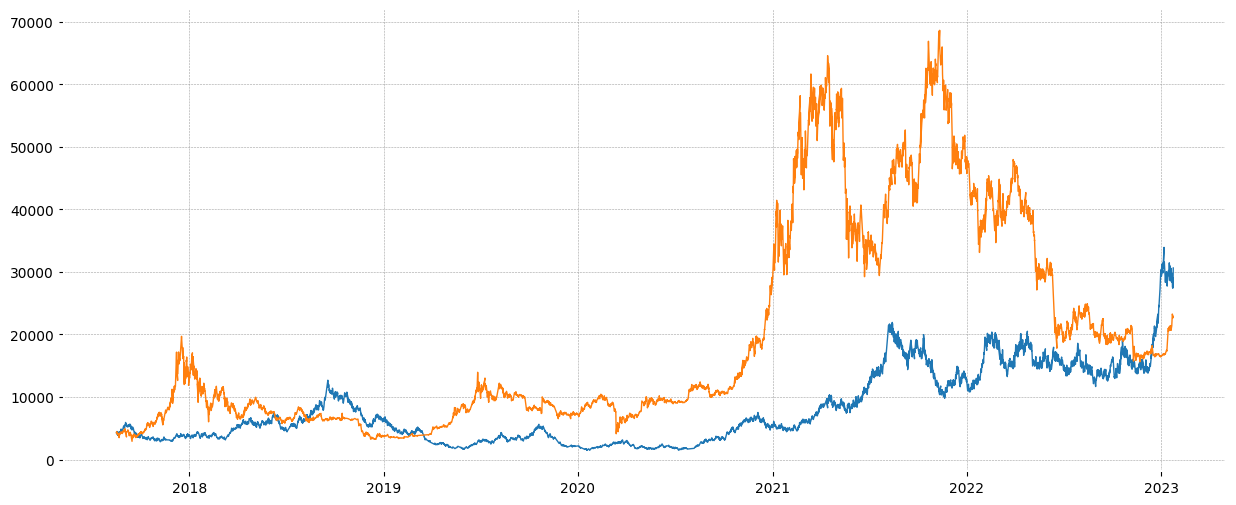

In [15]:
ds = generate_fake_data(df, 365)
fig, axes = plt.subplots(figsize=(15, 6))
axes.plot(ds["close"], linewidth=1)
axes.plot(df["close"], linewidth=1)
# axes.set_yscale("log")
plt.show()

In [16]:
ds.to_csv("../database/fake.csv")

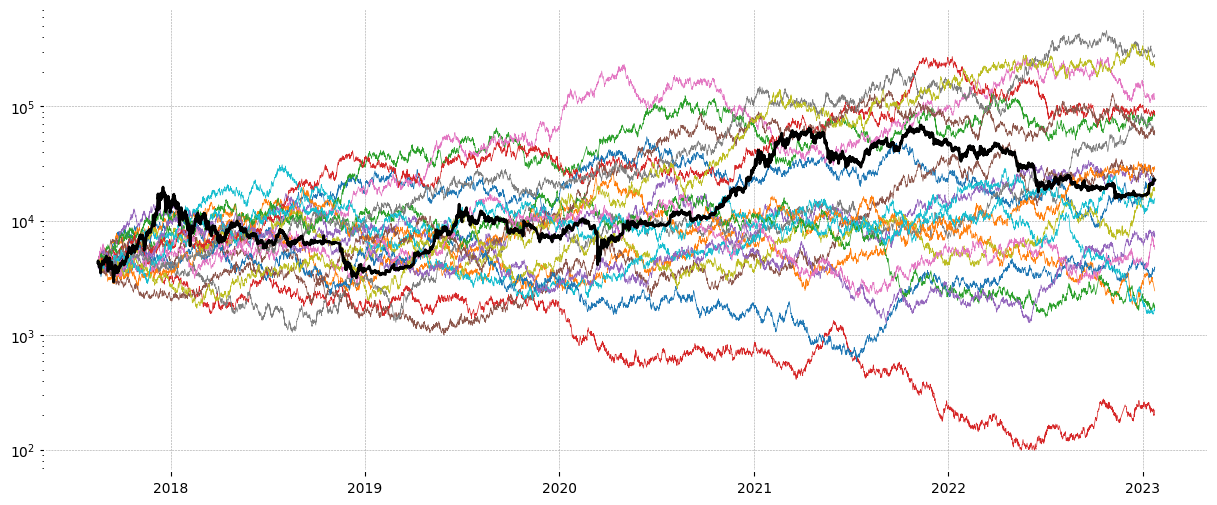

In [17]:
fig, axes = plt.subplots(figsize=(15, 6))
axes.set_yscale("log")
for i in range(20):
    di = generate_fake_data(df, 365)
    axes.plot(di["close"], linewidth=0.5)
axes.plot(df["close"], linewidth=2, color="black")

plt.show()